In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix

In [ ]:
df = pd.read_csv('fully_processed_data.csv')
df = df.drop('Unnamed: 0', axis=1)
df.head()

,myear,calcage,leader,deputy,support,disabled,hired,sherpa,tibetan,msuccess,mclaimed,mdisputed,msolo,mtraverse,mski,mparapente,mspeed,mo2none,mo2climb,mo2descent,mo2sleep,mo2medical,death,hcn,host,totmembers,tothired,nohired,citizen_is_nation,hired_ratio,0,1,2,3,4,5,6,7,8,9,...,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420
0,1988,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,17,10,0,1,0.588235,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1988,40,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,17,10,0,0,0.588235,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1988,29,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,17,10,0,0,0.588235,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1988,27,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,17,10,0,0,0.588235,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1988,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,17,10,0,0,0.588235,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
y_summit = df.msuccess
y_death = df.death
X = df.drop(['msuccess', 'death'], axis=1)

X_summit_train, X_summit_valid, y_summit_train, y_summit_valid = train_test_split(
    X, y_summit, train_size=0.8, test_size=0.2, random_state=0)

X_death_train, X_death_valid, y_death_train, y_death_valid = train_test_split(
    X, y_death, train_size=0.8, test_size=0.2, random_state=0)

##Summit

In [ ]:
summit_model = XGBClassifier(
                             early_stopping_rounds=10,
                             lr = 0.05,
                             n_estimators=500,
                             verbosity=1,
                             max_deapth=4
                             )

summit_model.fit(X_summit_train, y_summit_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
              gamma=0, learning_rate=0.1, lr=0.05, max_deapth=4,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
              n_estimators=500, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [ ]:
summit_predictions = summit_model.predict(X_summit_train)

print(accuracy_score(y_summit_train, summit_predictions))
print(log_loss(y_summit_train, summit_predictions))

0.9135201858844031
2.986965312355212


<Figure size 1080x432 with 0 Axes>

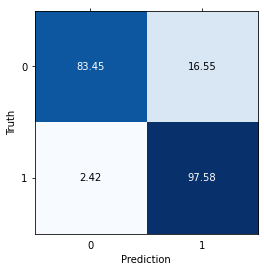

In [ ]:
plt.figure(figsize=(15, 6))

summit_confusion = confusion_matrix(y_summit_train, summit_predictions)

temp_con = []
for i in summit_confusion:
  temp = i / sum(i) * 100
  temp_con.append(temp)

summit_confusion = temp_con

#summit_confusion = summit_confusion / len(y_summit_train)

plt.matshow(summit_confusion, cmap = 'Blues')
        
for (i, j), z in np.ndenumerate(summit_confusion):
    if(0 < z < 50):
        plt.text(j, i, '{0:0.2f}'.format(z), ha='center', va='center', color =
                 'black')
        
    else:
        plt.text(j, i, '{0:0.2f}'.format(z), ha='center', va='center', color =
                 'white')
plt.ylabel("Truth")
plt.xlabel("Prediction")
plt.tick_params(bottom = False, top = True, labelbottom = True, labeltop = False)
plt.grid(True, which = 'minor')
#plt.savefig("Graphs/both32xsSNN.png", bbox_inches='tight', dpi=600)

##Death

In [ ]:
death_model = XGBClassifier(
                            early_stopping_rounds=10,
                            lr = 0.05,
                            n_estimators=500,
                            verbosity=1,
                            max_deapth=4
                            )

death_model.fit(X_death_train, y_death_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
              gamma=0, learning_rate=0.1, lr=0.05, max_deapth=4,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
              n_estimators=200, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [ ]:
death_predictions = death_model.predict(X_death_train)

print(accuracy_score(y_death_train, death_predictions))
print(log_loss(y_death_train, death_predictions))

0.9899070577984316
0.3485979899860193


<Figure size 1080x432 with 0 Axes>

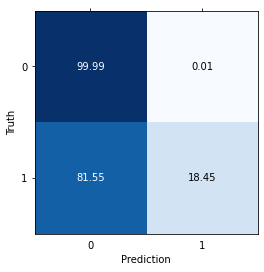

In [ ]:
plt.figure(figsize=(15, 6))

death_confusion = confusion_matrix(y_death_train, death_predictions)

temp_con = []
for i in death_confusion:
  temp = i / sum(i) * 100
  temp_con.append(temp)

death_confusion = temp_con

plt.matshow(death_confusion, cmap = 'Blues')
        
for (i, j), z in np.ndenumerate(death_confusion):
    if(0 < z < 50):
        plt.text(j, i, '{0:0.2f}'.format(z), ha='center', va='center', color =
                 'black')
        
    else:
        plt.text(j, i, '{0:0.2f}'.format(z), ha='center', va='center', color =
                 'white')
plt.ylabel("Truth")
plt.xlabel("Prediction")
plt.tick_params(bottom = False, top = True, labelbottom = True, labeltop = False)
plt.grid(True, which = 'minor')
#plt.savefig("Graphs/both32xsSNN.png", bbox_inches='tight', dpi=600)